In [1]:
import camb
import matplotlib.pyplot as plt
import numpy as np
import pickle as pl
from plancklens import utils
import emcee
import pymaster
import corner
import numpy as np
from getdist import plots, MCSamples
from camb import model, initialpower
import healpy as hp

In [2]:
fid = utils.camb_clfile('cmbs4_lensedCls.dat')['bb']

In [3]:
def get_spectra(r=0):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=r)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    pars.WantTensors = True if r is not 0 else False
    print("Setting Cosmology")
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    print("Power Spectra computed")
    return powers

In [4]:
def get_BB(component,r=0):
    result = get_spectra(r)
    if component == 'T':
        return result['tensor'].T[2]
    elif component == 'S':
        return result['lensed_scalar'].T[2]

def get_beam(beam):
    b = pymaster.NmtBin.from_nside_linear(512,10)
    fwhm = hp.gauss_beam(np.radians(beam/60.),b.lmax,True)[:,2]
    return b.bin_cell(fwhm)
def get_noise(level):
    b = pymaster.NmtBin.from_nside_linear(512,10)
    return np.ones(len(b.get_effective_ells())) * (np.radians(level/60)**2)

def get_bandpower(component, r=0, in_dl=True):
    bandpower = get_BB(component,r)
    b = pymaster.NmtBin.from_nside_linear(512,10)
    l = b.get_effective_ells()
    dl = l*(l+1)/(2*np.pi) if not in_dl else np.ones(l.shape)
    print("Bandpower calculated")
    return l,b.bin_cell(bandpower[:b.lmax + 1])  / dl
def get_bandpower_c(c,in_dl=True):
    b = pymaster.NmtBin.from_nside_linear(512,10)
    l = b.get_effective_ells()
    dl = l*(l+1)/(2*np.pi) if in_dl else np.ones(l.shape)
    return c*dl

def get_fid(in_dl=True):
    b = pymaster.NmtBin.from_nside_linear(512,10)
    l = b.get_effective_ells()
    dl = l*(l+1)/(2*np.pi) if in_dl else np.ones(l.shape)
    return l, b.bin_cell(fid[:b.lmax+1]) * dl


In [5]:
l,lensing = get_fid(in_dl=False)

In [6]:
l,tensor_p1 = get_bandpower("T",r=.1,in_dl=False)

Setting Cosmology
Power Spectra computed
Bandpower calculated


In [7]:
l,tensor_p1 = get_bandpower("T",r=.1,in_dl=False)

Setting Cosmology
Power Spectra computed
Bandpower calculated


In [7]:
pl.dump(tensor,open('../tensor.pkl','wb'))

In [7]:
l,lensing = get_fid(in_dl=False)

In [8]:
pl.dump(lensing,open('lensing.pkl','wb'))

NameError: name 'tensor' is not defined

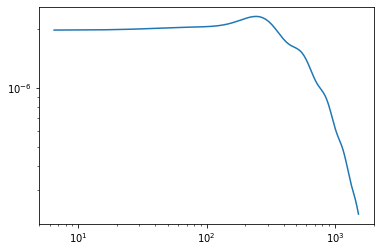

In [9]:
plt.loglog(l,lensing)
plt.loglog(l,tensor)

In [31]:
def cl_th(r,Alens):
    return ((r/0.1) * tensor_p1) + (Alens * lensing)

be = get_beam(30)
no = get_noise(1.5)
def cl_th_new(r,Alens):
    th = ((r/0.1) * tensor_p1) + (Alens * lensing)
    return th*be**2 +  no
     

In [35]:
def chi_sq(theta,l,cl):
    sel = np.where((30 <l) & (l <180))[0]
    r,Alens = theta
    cl_t = cl_th_new(r,Alens)
    w = (2*l[sel]) + 1
    first  = np.log(cl_t/cl)[sel]
    second = (cl/cl_t)[sel]
    return  -.5 * np.nansum(w*(first+second-1))

In [24]:
def log_prior(theta):
    r, Alens = theta
    if -0.5 < r < 0.5 and 0 < Alens <1.5:
        return 0.0
    return -np.inf

def log_probability(theta, l, cl):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + chi_sq(theta, l, cl)

In [36]:
def posterior(spectra,plot=False):
    #spectra = ten_te_bb+len_bb
    pos = np.array([0.1,.1]) + 1e-4 * np.random.randn(100, 2)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,spectra))
    sampler.run_mcmc(pos, 2000, progress=True)
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    if plot:
        labels = ["r","Alens"]
        fig = corner.corner(flat_samples, labels=labels)
    return flat_samples

In [12]:
l,tensor_p01 = get_bandpower('T',r=.01,in_dl=False)
l,tensor_p001 = get_bandpower('T',r=.001,in_dl=False)

Setting Cosmology
Power Spectra computed
Bandpower calculated
Setting Cosmology
Power Spectra computed
Bandpower calculated


In [17]:
def get_samples(lb_samples,r_g=None,A_g=None):
    names = ['r','Alens']
    labels = names
    if r_g is not None:
        lb_samples = lb_samples[lb_samples[:,0] > r_g,:]
    if A_g is not None:
        lb_samples = lb_samples[lb_samples[:,1] > A_g,:]
    return MCSamples(samples=lb_samples,names = names, labels = labels, label='test')

def plot(lb,r_g=None,A_g=None):
    lb_samples = get_samples(lb,r_g,A_g)

    g = plots.get_subplot_plotter(width_inch=8)
    g.triangle_plot([lb_samples], filled=True)

In [114]:
#lb = posterior(lensing)
#plot(lb,-0.001)

In [115]:
# lb = posterior(tensor_p01+lensing)
# plot(lb)

In [116]:
# lb = posterior(tensor_p001+lensing)
# plot(lb)

  0%|          | 14/5000 [00:00<00:35, 138.81it/s]/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
100%|██████████| 5000/5000 [00:36<00:00, 137.60it/s]


Removed no burn in


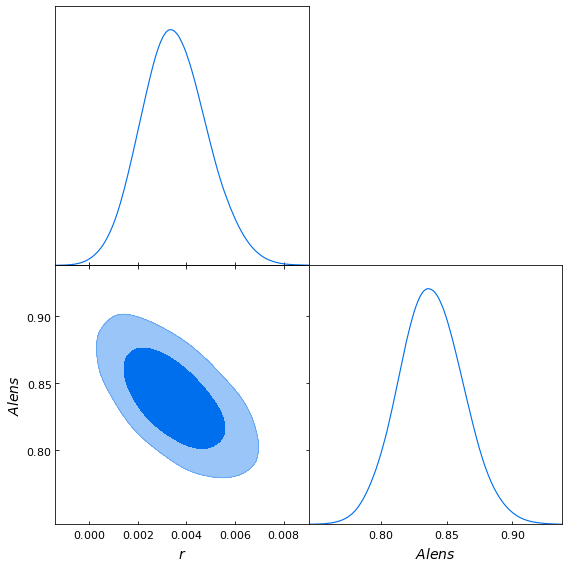

In [115]:
lb = posterior((.8*lensing*get_beam(30)) + get_noise(2.15))
plot(lb)

  1%|          | 30/5000 [00:00<00:36, 137.64it/s]/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
100%|██████████| 5000/5000 [00:36<00:00, 136.53it/s]


Removed no burn in


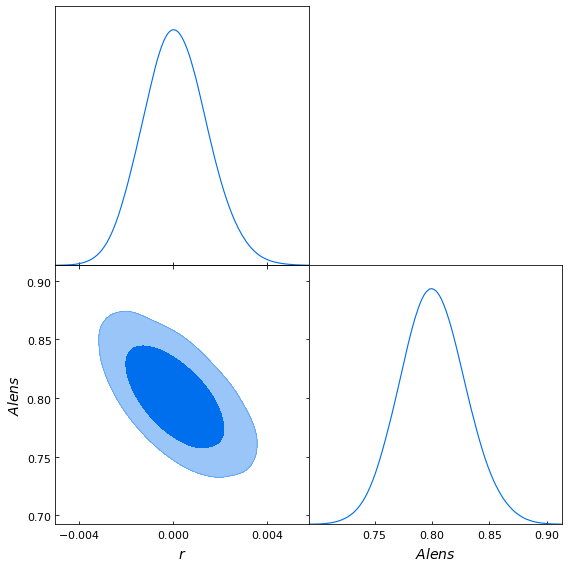

In [117]:
lb = posterior((.8*lensing*get_beam(30)) + get_noise(2.15))
plot(lb)

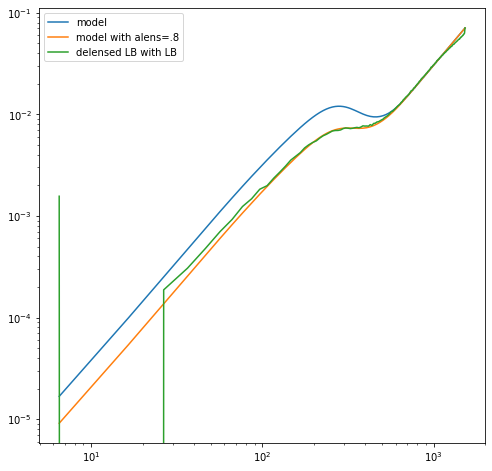

In [33]:
plt.figure(figsize=(8,8))
plt.loglog(l,(lensing*get_beam(30)**2 + get_noise(1.5))*l*(l+1)/(2*np.pi),label='model')
plt.loglog(l,((.5*lensing*get_beam(30)**2) + get_noise(1.5))*l*(l+1)/(2*np.pi),label='model with alens=.8')
plt.loglog(l,pl.load(open('lb_s4.pkl','rb'))*l*(l+1)/(2*np.pi),label='delensed LB with LB')
plt.legend()

  0%|          | 22/5000 [00:00<00:45, 109.16it/s]/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
100%|██████████| 5000/5000 [00:42<00:00, 119.02it/s]


Removed no burn in


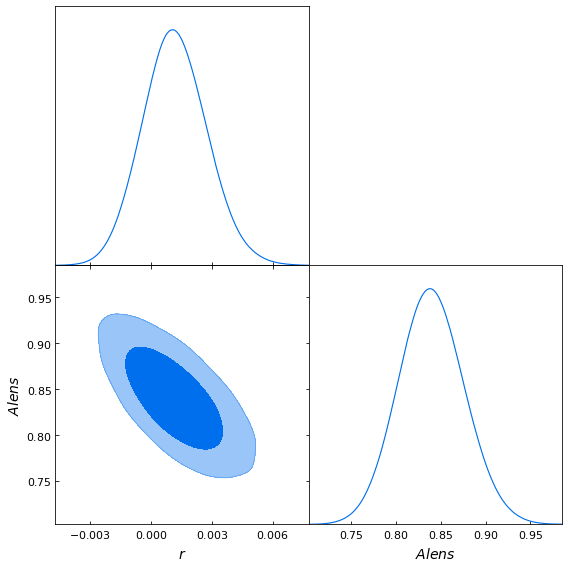

In [25]:
data = pl.load(open('lb.pkl','rb'))
lb = posterior(data)
plot(lb)

/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
100%|██████████| 2000/2000 [00:18<00:00, 106.44it/s]


Removed no burn in


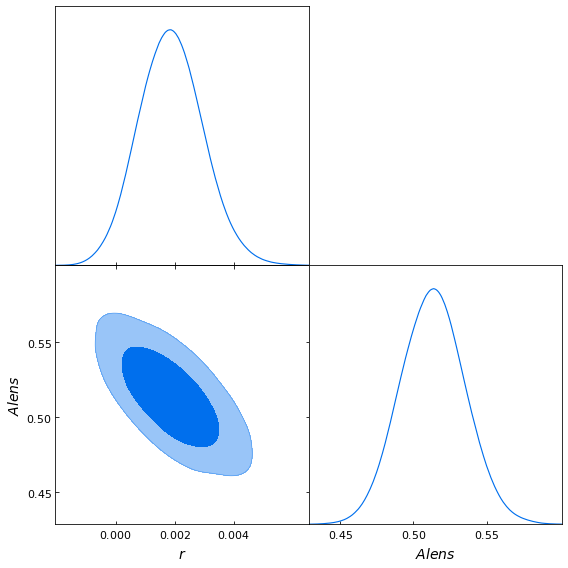

In [37]:
data = pl.load(open('lb_s4.pkl','rb'))
lb = posterior(data)
plot(lb)